# Overview of the data

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [4]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Schema diagram
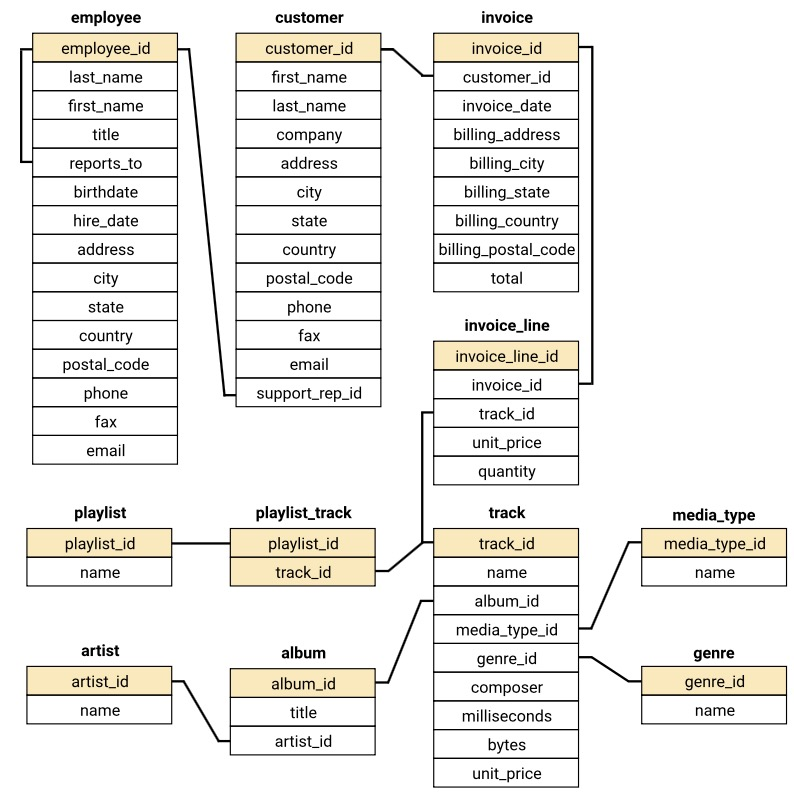

# Selecting albums to purchase
We need to identify which genres sell the most tracks in the USA so we can determine which albums we should purchase for the store.

In [33]:
%%sql
WITH
    tracks_sold_usa AS
    (
    SELECT
        t.track_id,
        t.name,
        t.genre_id,
        t.unit_price,
        SUM(il.quantity) quantity
    FROM track t
    LEFT JOIN invoice_line il ON il.track_id = t.track_id
    LEFT JOIN invoice i ON i.invoice_id =  il.invoice_id
    WHERE i.billing_country = 'USA'    
    GROUP BY t.track_id
    ),
    
    total_tracks_sold_usa AS
    (
    SELECT
        SUM(ts.quantity) total_tracks_sold
    FROM tracks_sold_usa ts
    )
    
SELECT
    g.name genre,
    SUM(ts.quantity) tracks_sold_usa,
    ROUND((SUM(ts.quantity)*100.0) / (SELECT total_tracks_sold FROM total_tracks_sold_usa),2) percentage_of_total_usa
FROM genre g
LEFT JOIN tracks_sold_usa ts ON ts.genre_id = g.genre_id
GROUP BY 1 ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


genre,tracks_sold_usa,percentage_of_total_usa
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Pop,22,2.09
Latin,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


Considering the results above, here are the options that we have to purchase ranked based on tracks sold by that genre:


| Artist name | Genre | Relative rank |
| :- | :- | :-: |
| Regal | Hip-hop | 4 |
| Red Tone | Punk | 1 |
| Meteor and the Girls | Pop | 3 |
| Slim Jim Bites| Blues | 2 |

Based on this, the artists we should buy are:
1. Red Tone (Punk)
2. Slim Jim Bites (Blues)
3. Meteor and the Girls (Pop)

# Analysing Employee Sales Performace

In [39]:
%%sql
WITH
    customer_sales AS
    (
    SELECT
        c.*,
        SUM(i.total) customer_total
    FROM customer c
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.customer_id
    )
    
SELECT
    e.first_name||" "||e.last_name employee_name,
    e.title employee_title,
    e.hire_date,
    SUM(cs.customer_total) sales_total
FROM employee e
LEFT JOIN customer_sales cs ON cs.support_rep_id = e.employee_id
GROUP BY e.employee_id
ORDER BY 2,4 DESC;

 * sqlite:///chinook.db
Done.


employee_name,employee_title,hire_date,sales_total
Andrew Adams,General Manager,2016-08-14 00:00:00,None
Michael Mitchell,IT Manager,2016-10-17 00:00:00,None
Robert King,IT Staff,2017-01-02 00:00:00,None
Laura Callahan,IT Staff,2017-03-04 00:00:00,None
Nancy Edwards,Sales Manager,2016-05-01 00:00:00,None
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.0
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


Looking at the sales data above we can see that sales are only completed by the three Sales Support Agents. Across these three staff there is some variance in sales numbers (\\$1731.51 to \\$1393.92) however does not appear to be a significant range, especially when considering the hire dates of the Sales Support Agents, which directly correlate with the sales total sequence.

# Analysing sales by country

In [59]:
%%sql
WITH
    cust_by_country AS
    (
    SELECT
        c.country,
        COUNT(distinct c.customer_id) no_customers,
        SUM(i.total) total_sales,
        COUNT(i.invoice_id) no_orders
    FROM customer c
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.country
    ),
    
    cust_by_country2 AS
    (
    SELECT
        CASE
            WHEN c.no_customers <= 1 THEN "Other"
            ELSE c.country
            END country,
        SUM(c.no_customers) no_customers,
        SUM(c.total_sales) total_sales,
        SUM(c.no_orders) no_orders,
        CASE
            WHEN c.no_customers <= 1 THEN 1
            ELSE 0
            END sort
    FROM cust_by_country c
    GROUP BY 1
    )
    
SELECT
    country,
    no_customers,
    ROUND(total_sales,2) total_sales,
    ROUND((total_sales/no_customers),2) avg_sales_per_customer,
    ROUND((total_sales/no_orders),2) avg_order_value
FROM cust_by_country2 c2
ORDER BY sort, total_sales DESC;

 * sqlite:///chinook.db
Done.


country,no_customers,total_sales,avg_sales_per_customer,avg_order_value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


# Analysing Album vs Individual Track Purchases

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [96]:
%%sql
WITH
    invoice_album AS
    (
    SELECT
        i.invoice_id,
        il.invoice_line_id,
        t.album_id,
        il.track_id
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    ),
    
    album_track AS
    (
    SELECT
        t.album_id,
        t.track_id
    FROM track t
    ),
    
    complete_album_purchases AS
    (
    SELECT
        ia.invoice_id,
        ia.album_id,
        CASE
            WHEN    (
                    SELECT ia2.track_id FROM invoice_album ia2 WHERE ia2.album_id = ia.album_id AND ia2.invoice_id = ia.invoice_id
                    EXCEPT
                    SELECT at.track_id FROM album_track at WHERE at.album_id = ia.album_id
                    ) IS NULL
            AND     (
                    SELECT at.track_id FROM album_track at WHERE at.album_id = ia.album_id
                    EXCEPT
                    SELECT ia2.track_id FROM invoice_album ia2 WHERE ia2.album_id = ia.album_id AND ia2.invoice_id = ia.invoice_id
                    ) IS NULL
            THEN "complete"
            ELSE "incomplete"
            END AS complete_album
    FROM invoice_album ia
    GROUP BY 1
    )
    
SELECT
    cap.complete_album,
    COUNT(cap.invoice_id) no_invoices,
    ROUND((CAST(COUNT(cap.invoice_id) AS Float) / (SELECT COUNT(*) FROM complete_album_purchases)) * 100, 2) percentage_of_invoices
FROM complete_album_purchases cap
GROUP BY 1;

 * sqlite:///chinook.db
Done.


complete_album,no_invoices,percentage_of_invoices
complete,130,21.17
incomplete,484,78.83


Based on the analysis above we can see that the majority of purchases are individual tracks and not complete albums. Management needs to decide how relevant this is.